# Fluid Simulation with Cosmic Rays

## Imports

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "9"

import jax.numpy as jnp
import matplotlib.pyplot as plt

from jf1uids.option_classes.simulation_config import SPHERICAL
from jf1uids import SimulationConfig
from jf1uids import SimulationParams
from jf1uids import get_helper_data
from jf1uids.fluid_equations.fluid import construct_primitive_state
from jf1uids import get_registered_variables
from jf1uids.option_classes.simulation_config import finalize_config


from jf1uids import time_integration

## Simulation Setup

Let us set up a very simple simulation, mostly with default parameters - except for the inclusion of Cosmic Rays.

In [ ]:
from jf1uids._physics_modules._cosmic_rays.cosmic_ray_options import CosmicRayConfig
from jf1uids.option_classes.simulation_config import CARTESIAN, HLL, MINMOD, OSHER

config = SimulationConfig(
    geometry = CARTESIAN,
    first_order_fallback = False,
    num_cells = 1001,
    box_size = 10.0,
    cosmic_ray_config = CosmicRayConfig(
        cosmic_rays = True,
        diffusive_shock_acceleration = False
    ),
    riemann_solver = HLL,
    runtime_debugging = False,
    # limiter = OSHER,
)

Next we setup the simulation parameters, things we might vary

In [3]:
from jf1uids._physics_modules._cosmic_rays.cosmic_ray_options import CosmicRayParams


params = SimulationParams(
    t_end = 0.35,
    cosmic_ray_params = CosmicRayParams(
        diffusive_shock_acceleration_efficiency = 0.5,
        diffusive_shock_acceleration_start_time = 0.0
    )
)

With this we generate some helper data, like the cell centers etc.

In [4]:
helper_data = get_helper_data(config)
registered_variables = get_registered_variables(config)

Next we setup the shock initial conditions

In [5]:
shock_pos = 5.0
r = helper_data.geometric_centers
rho = jnp.where(r < shock_pos, 1.0, 0.125)
u = jnp.zeros_like(r)
p_gas = jnp.where(r < shock_pos, 17.172, 0.05)

# cosmic ray setup
p_cr = jnp.where(r < shock_pos, 34.344, 0.05)
gamma_cr = 4/3
n_cr = p_cr ** (1/gamma_cr)

# get initial state
initial_state = construct_primitive_state(
    registered_variables = registered_variables,
    config = config,
    density = rho,
    velocity_x = u,
    gas_pressure = p_gas,
    cosmic_ray_pressure = p_cr
)

config = finalize_config(config, initial_state.shape)

Automatically setting open boundaries for Cartesian geometry.


## Running the simulation

In [6]:
final_state = time_integration(initial_state, config, params, helper_data, registered_variables)
rho_final = final_state[registered_variables.density_index]
u_final = final_state[registered_variables.velocity_index]
p_final = final_state[registered_variables.pressure_index]
n_cr_final = final_state[registered_variables.cosmic_ray_n_index]
p_cr_final = n_cr_final ** gamma_cr
p_gas_final = p_final - p_cr_final

In [7]:
config2 = config._replace(
    cosmic_ray_config = CosmicRayConfig(
                            cosmic_rays = True,
                            diffusive_shock_acceleration = True,
                        )
)

config2 = finalize_config(config2, initial_state.shape)

final_state_acc = time_integration(initial_state, config2, params, helper_data, registered_variables)
rho_final_acc = final_state_acc[registered_variables.density_index]
u_final_acc = final_state_acc[registered_variables.velocity_index]
p_final_acc = final_state_acc[registered_variables.pressure_index]
n_cr_final_acc = final_state_acc[registered_variables.cosmic_ray_n_index]
p_cr_final_acc = n_cr_final_acc ** gamma_cr
p_gas_final_acc = p_final_acc - p_cr_final_acc

In [8]:
# get the analytic solution
from analytic_solution import get_cosmic_ray_analytic_solution

x_full, rho_full, velocity_full, thermal_pressure_full, cosmic_ray_pressure_full, total_pressure_full = get_cosmic_ray_analytic_solution(
    thermal_pressure_left = 17.172,
)

x_full_no_inj, rho_full_no_inj, velocity_full_no_inj, thermal_pressure_full_no_inj, cosmic_ray_pressure_full_no_inj, total_pressure_full_no_inj = get_cosmic_ray_analytic_solution(
    thermal_pressure_left = 17.172,
    injection_efficiency= 0.0,
)

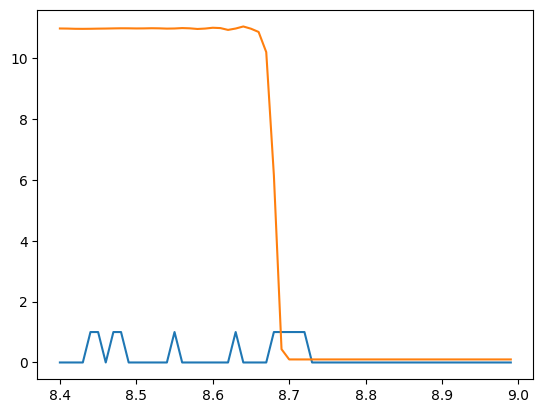

In [9]:
from jf1uids.shock_finder.shock_finder import shock_criteria
shock_crit = shock_criteria(final_state_acc, registered_variables)

a = 8.4
b = 9.0

mask = jnp.logical_and(r > a, r < b)

plt.plot(r[mask], shock_crit[mask], label = "shock criteria")
plt.plot(r[mask], p_final_acc[mask], label = "rho final")

## Visualization

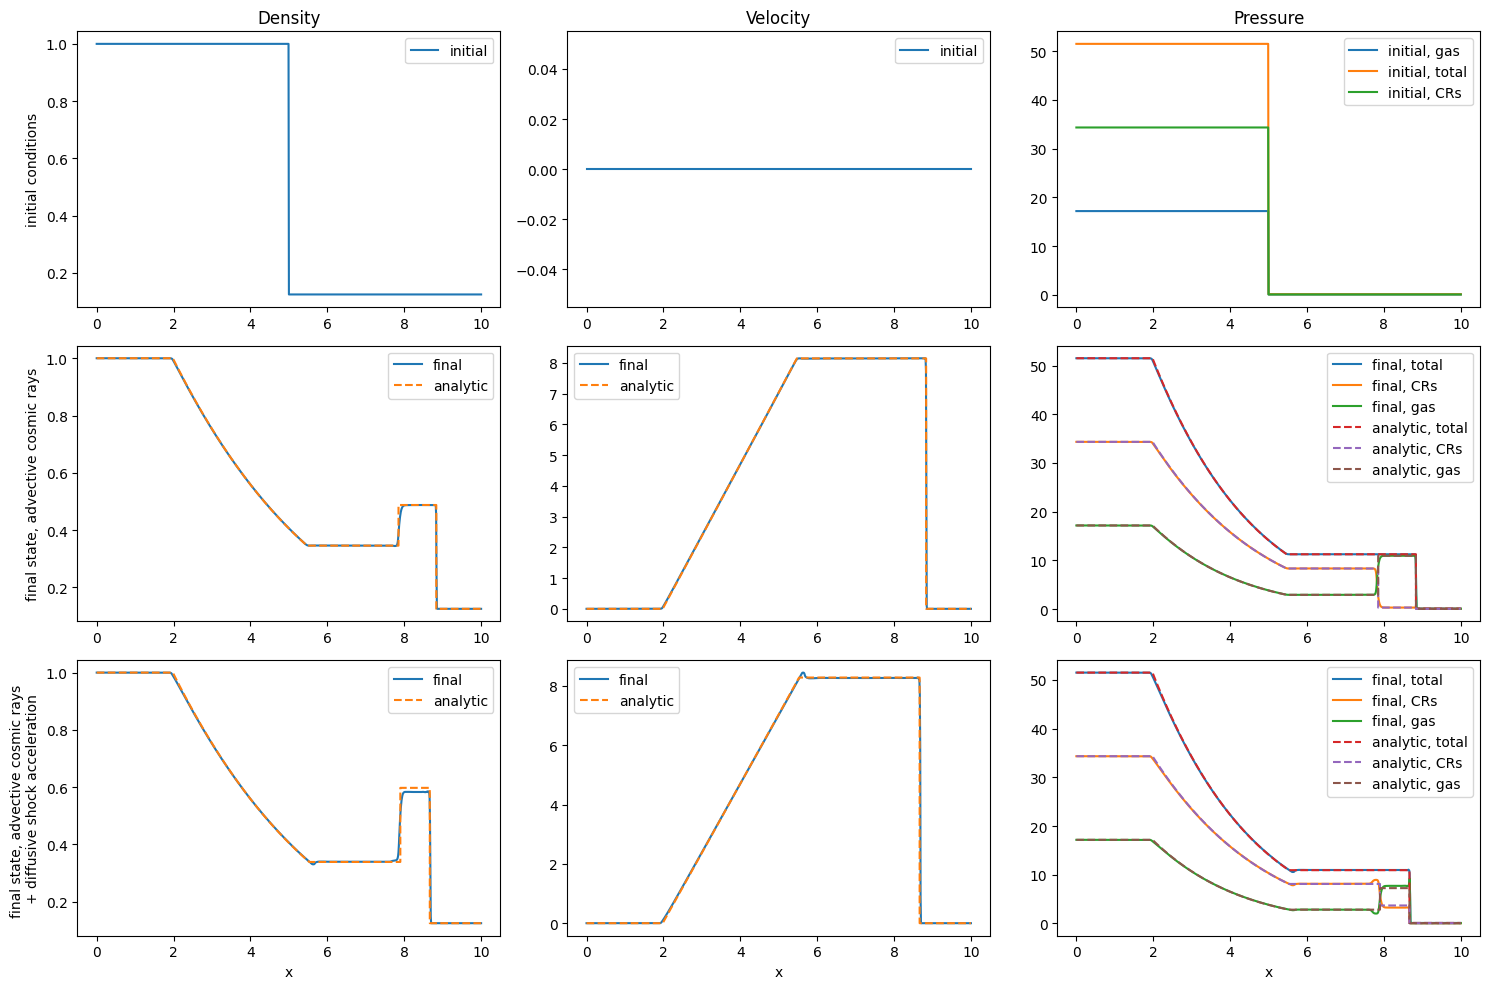

In [10]:
from jf1uids.shock_finder.shock_finder import find_shock_zone, shock_criteria

fig, axs = plt.subplots(3, 3, figsize=(15, 10))

axs[0, 0].plot(r, rho, label='initial')
axs[1, 0].plot(r, rho_final, label='final')
axs[1, 0].plot(x_full_no_inj, rho_full_no_inj, label='analytic', ls='--')
axs[0, 0].set_title('Density')
axs[0, 0].legend()
axs[1, 0].legend()

axs[0, 1].plot(r, u, label='initial')
axs[1, 1].plot(r, u_final, label='final')
axs[1, 1].plot(x_full_no_inj, velocity_full_no_inj, label='analytic', ls='--')
axs[0, 1].set_title('Velocity')
axs[0, 1].legend()
axs[1, 1].legend()

axs[0, 2].plot(r, p_gas, label='initial, gas')
axs[0, 2].plot(r, p_gas + p_cr, label='initial, total')
axs[1, 2].plot(r, p_final, label='final, total')
axs[0, 2].plot(r, p_cr, label='initial, CRs')
axs[1, 2].plot(r, p_cr_final, label='final, CRs')
axs[1, 2].plot(r, p_gas_final, label='final, gas')

axs[1, 2].plot(x_full_no_inj, total_pressure_full_no_inj, label='analytic, total', ls='--')
axs[1, 2].plot(x_full_no_inj, cosmic_ray_pressure_full_no_inj, label='analytic, CRs', ls='--')
axs[1, 2].plot(x_full_no_inj, thermal_pressure_full_no_inj, label='analytic, gas', ls='--')


axs[0, 2].set_title('Pressure')
axs[0, 2].legend()
axs[1, 2].legend()

axs[2, 0].plot(r, rho_final_acc, label='final')
axs[2, 0].plot(x_full, rho_full, label='analytic', ls='--')

axs[2, 1].plot(r, u_final_acc, label='final')
axs[2, 1].plot(x_full, velocity_full, label='analytic', ls='--')

_, left_idx, right_idx = find_shock_zone(final_state_acc, registered_variables)
a = r[left_idx] - 0.06
b = r[right_idx] + 0.06

axs[2, 2].plot(r, p_final_acc, label='final, total')
axs[2, 2].plot(r, p_cr_final_acc, label='final, CRs')
axs[2, 2].plot(r, p_gas_final_acc, label='final, gas')
axs[2, 2].plot(x_full, total_pressure_full, label='analytic, total', ls='--')
axs[2, 2].plot(x_full, cosmic_ray_pressure_full, label='analytic, CRs', ls='--')
axs[2, 2].plot(x_full, thermal_pressure_full, label='analytic, gas', ls='--')

axs[2, 0].legend()
axs[2, 1].legend()
axs[2, 2].legend()

axs[2, 0].set_xlabel('x')
axs[2, 1].set_xlabel('x')
axs[2, 2].set_xlabel('x')

axs[0, 0].set_ylabel("initial conditions")
axs[1, 0].set_ylabel("final state, advective cosmic rays")
axs[2, 0].set_ylabel("final state, advective cosmic rays \n+ diffusive shock acceleration")

plt.tight_layout()
plt.savefig('cosmic_ray_shock.svg')


866 870


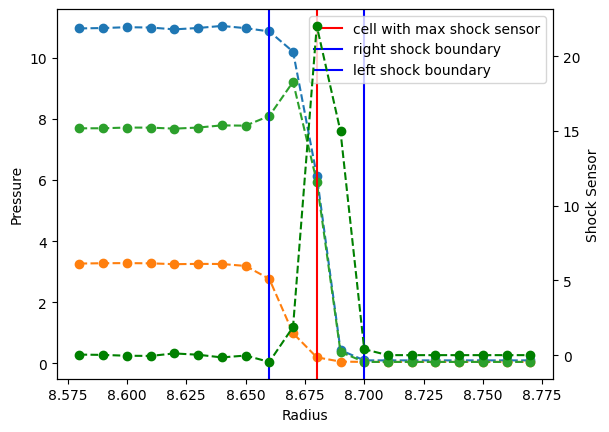

In [11]:
from jf1uids.shock_finder.shock_finder import find_shock_zone, shock_sensor

shock_index = jnp.argmax(shock_sensor(final_state_acc[registered_variables.pressure_index]))

max_shock_index, shock_index_right, shock_index_left = find_shock_zone(final_state_acc, registered_variables)

print(shock_index_right, shock_index_left)

ax1 = plt.gca()
ax1.plot(helper_data.geometric_centers[shock_index - 10:shock_index + 10], final_state_acc[registered_variables.pressure_index, shock_index - 10:shock_index + 10], "o--")
ax1.plot(helper_data.geometric_centers[shock_index - 10:shock_index + 10], p_cr_final_acc[shock_index - 10:shock_index + 10], "o--")
ax1.plot(helper_data.geometric_centers[shock_index - 10:shock_index + 10], p_gas_final_acc[shock_index - 10:shock_index + 10], "o--")
# mark vertical line at the shock
ax2 = plt.gca().twinx()
ax2.plot(helper_data.geometric_centers[shock_index - 10:shock_index + 10], shock_sensor(final_state_acc[registered_variables.pressure_index])[shock_index - 10:shock_index + 10], "o--", color='green')
ax2.set_ylabel('Shock Sensor')
ax1.axvline(helper_data.geometric_centers[shock_index], color='red', label='cell with max shock sensor')
ax1.axvline(helper_data.geometric_centers[shock_index_right], color='blue', label='right shock boundary')
ax1.axvline(helper_data.geometric_centers[shock_index_left], color='blue', label='left shock boundary')
ax1.set_ylabel('Pressure')
ax1.set_xlabel('Radius')
ax1.legend(loc = 'upper right')

In [12]:
p_gas_final_acc[jnp.argmin(jnp.abs(r - 6.0))]

Array(2.8406, dtype=float32)

In [13]:
p_cr_final_acc[jnp.argmin(jnp.abs(r - 6.0))]

Array(8.141825, dtype=float32)

In [14]:
p_gas_final_acc[jnp.argmin(jnp.abs(r - 8.0))]

Array(7.612386, dtype=float32)

In [15]:
p_cr_final_acc[jnp.argmin(jnp.abs(r - 8.0))]

Array(3.3617015, dtype=float32)